In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime as dt
import meteomatics.api as api
from shapely.geometry import Point, Polygon
from module import get_netcdf, make_mask

---


## Download Data

In [4]:
lat_N = -12.167468
lon_W = -75.1398261
lat_S = -15.630065
lon_E = -72.8468246
res_lat = 0.01
res_lon = 0.01

coordinates = [lat_N,lon_W,lat_S,lon_E]
resolution = [res_lat,res_lon]
# parameters = 't_2m:C'
# parameters = 'relative_humidity_2m:p'
parameters = ["t_2m:C","relative_humidity_2m:p"]
parameters = "t_2m:C,relative_humidity_2m:p"

# get_netcdf(coordinates, resolution, parameters, interval=1, before=5, after=1)

---

In [5]:
prov_path = 'data\peru_provincial_simple.geojson'
dept_path = 'data\peru_departamental_simple.geojson'

# Cargar el archivo provincial
data_prov = gpd.read_file(prov_path)

# Cargar el archivo departamental para Ayacucho
data_dept = gpd.read_file(dept_path)


---

PARA EDWARD



In [6]:
import xarray as xr

ds_RH = xr.open_dataset('./relative_humidity_2mp__2024_10_1__2024_10_7-12_0.nc')
ds_T = xr.open_dataset('./t_2mC__2024_10_1__2024_10_7-12_0.nc')

df_RH = ds_RH.to_dataframe()
df_T = ds_T.to_dataframe()

df_RH_T = df_T.join(df_RH, lsuffix="T")

---


In [34]:
# Abrir el archivo NetCDF
ds = xr.open_dataset('t_2mC__2024_10_1__2024_10_7-12_0.nc') # array
P = ds.data_vars['t_2m'].values[1, :, :] # matrix data for T parameter

lons = ds.coords['longitude'].values # longitude values
lats = ds.coords['latitude'].values # latitude values

In [35]:
# POLÍGONOS PARA FILTRAR LA REGIÓN
# Filtrar para obtener solo el departamento de Ayacucho
ayacucho = data_dept[data_dept['NOMBDEP'] == 'AYACUCHO']
ayacucho_polygon = ayacucho.geometry[4]

# AFiltrar para obtener solo las provincias de Ayacucho
ayacucho_prov = data_prov[data_prov['FIRST_NOMB'] == 'AYACUCHO']
prov_polygon = ayacucho_prov[ayacucho_prov['NOMBPROV'] == 'HUAMANGA'].geometry[79]

---

In [36]:
# DATA MASKED
P_masked = make_mask(lons, lats, prov_polygon, P)
P_masked = make_mask(lons, lats, ayacucho_polygon, P)

In [37]:
P_masked

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [158]:
def plot_dep(lons, lats, parameter, data, departament="AYACUCHO", save=False):

    # Filter geopandas according to departament
    dept = data[data['NOMBDEP'] == departament]

    # Get polygon for department
    dept_polygon = dept.geometry.values[0]

    # Mask parameter matrix according to department polygon
    P_masked = make_mask(lons, lats, dept_polygon, parameter)

    ################################

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(5, 6))

    # Graficar el contorno de temperatura sobre los ejes
    contorno = ax.contourf(lons, lats, P_masked, cmap='magma', levels=50)
    cbar = plt.colorbar(contorno, ax=ax, label='T (°C)',fraction=0.046, pad=0.04, shrink=0.8)

    # Graficar los límites del departamento de Ayacucho sobre el mismo eje
    # dept.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
    dept.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

    # Personalizar el gráfico
    ax.set_title(departament)
    ax.axis('off')

    # Save figure
    if save:
        plt.savefig("ayacucho_T.png")

    # Mostrar el gráfico combinado
    plt.show()
    

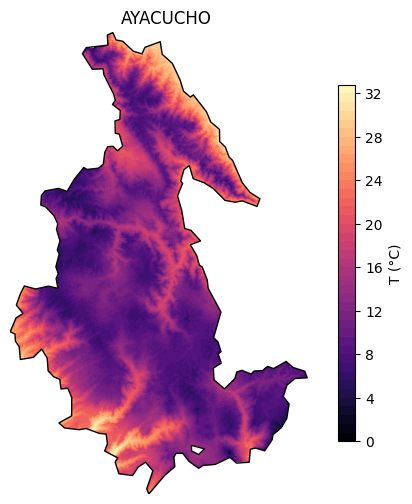

In [159]:
plot_dep(lons, lats, P, data_dept)


In [140]:
def plot_prov(lons, lats, parameter, data, departament="AYACUCHO", province="HUAMANGA"):

    # Filter geopandas according to departament for all province
    dept_prov = data[data['FIRST_NOMB'] == departament]

    # Filter geopandas according to a province
    prov = dept_prov[dept_prov['NOMBPROV'] == province]

    # Get polygon for department
    dept_polygon = prov.geometry.values[0]

    # Mask parameter matrix according to department polygon
    P_masked = make_mask(lons, lats, dept_polygon, parameter)

    ################################

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(13.9, 6))

    # Graficar el contorno de temperatura sobre los ejes
    contorno = ax.contourf(lons, lats, P_masked, cmap='magma', levels=50)

    # Graficar los límites del departamento de Ayacucho sobre el mismo eje
    # ayacucho.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
    prov.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

    minx, miny, maxx, maxy = prov.total_bounds
    ax.set_xlim(minx-0.05,maxx+0.05)
    ax.set_ylim(miny-0.5,maxy+0.5)

    # Personalizar el gráfico
    ax.set_title(f"{province} - {departament}")
    ax.axis('off')

    # Mostrar el gráfico combinado
    plt.show()
    

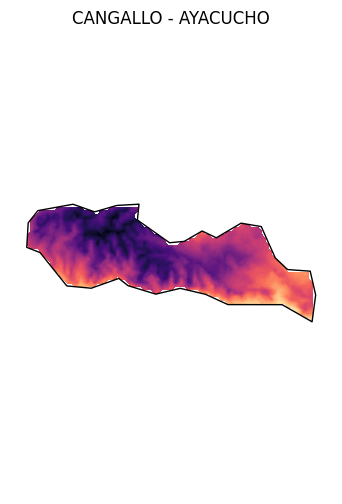

In [148]:
plot_prov(lons, lats, P, data_prov, province="CANGALLO")

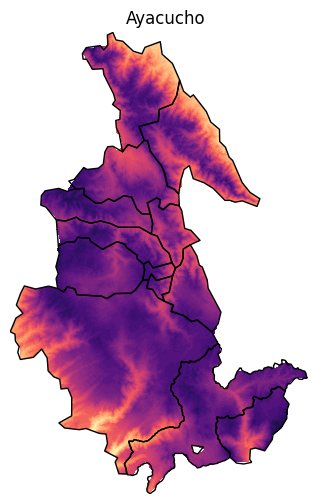

In [56]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(13.9, 6))

# Graficar el contorno de temperatura sobre los ejes
contorno = ax.contourf(lons, lats, P_masked, cmap='magma', levels=50)
# cbar = plt.colorbar(contorno, ax=ax, label='T (°C)')

# Graficar los límites del departamento de Ayacucho sobre el mismo eje
# ayacucho.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
ayacucho_prov.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Personalizar el gráfico
ax.set_title('Ayacucho')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

ax.axis('off')

# Mostrar el gráfico combinado
plt.show()


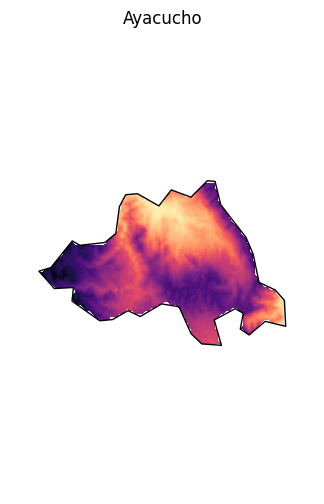

In [128]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(13.9, 6))

# Graficar el contorno de temperatura sobre los ejes
contorno = ax.contourf(lons, lats, P_masked, cmap='magma', levels=50)
# cbar = plt.colorbar(contorno, ax=ax, label='T (°C)')

# Graficar los límites del departamento de Ayacucho sobre el mismo eje
# ayacucho.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
huaman = ayacucho_prov[ayacucho_prov['NOMBPROV'] == 'HUAMANGA']
huaman.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
minx, miny, maxx, maxy = huaman.total_bounds

# Personalizar el gráfico
ax.set_title('Ayacucho')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

ax.set_xlim(minx-0.1,maxx+0.1)
ax.set_ylim(miny-0.5,maxy+0.5)


ax.axis('off')

# Mostrar el gráfico combinado
plt.show()

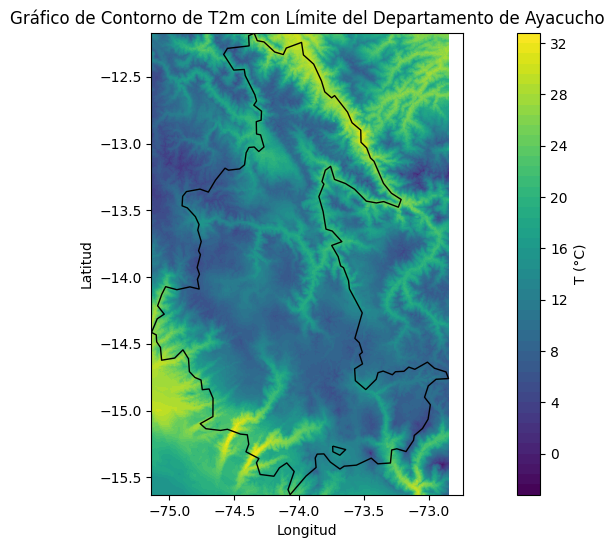

In [187]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(13.9, 6))

# Graficar el contorno de temperatura sobre los ejes
contorno = ax.contourf(lons, lats, P, cmap='viridis', levels=50)
cbar = plt.colorbar(contorno, ax=ax, label='T (°C)')

# Graficar los límites del departamento de Ayacucho sobre el mismo eje
ayacucho.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Personalizar el gráfico
ax.set_title('Gráfico de Contorno de T2m con Límite del Departamento de Ayacucho')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico combinado
plt.show()


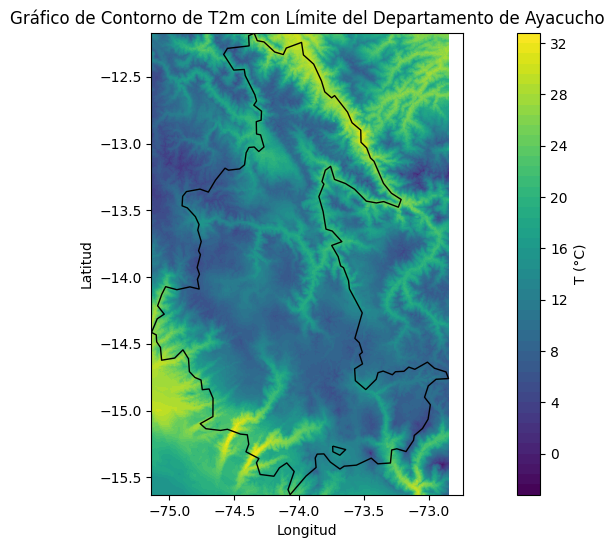

In [267]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(13.9, 6))

# Graficar el contorno de temperatura sobre los ejes
contorno = ax.contourf(lons, lats, P, cmap='viridis', levels=50)
cbar = plt.colorbar(contorno, ax=ax, label='T (°C)')

# Graficar los límites del departamento de Ayacucho sobre el mismo eje
ayacucho.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Personalizar el gráfico
ax.set_title('Gráfico de Contorno de T2m con Límite del Departamento de Ayacucho')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico combinado
plt.show()

---


In [8]:
def get_timeseries(coordinates, parameters, interval=12, before=0, after=7, model='mix'):

    '''
    Get dataframe from meteomatics API.
    Coordinates format: [(x1,y1),(x2,y2),...]
    Parameters format: ["t_2m:C","precip_1h:mm"] 
    Intervals: hours
    Before: Days before now (past)
    After: Days after now (forecast)
    '''

    # Credentials
    username = 'burgos_alexander'
    password = 'NF0xCcC38p'
    
    # Date and time limits
    today = dt.datetime.utcnow().replace(hour=12, minute=0, second=0, microsecond=0)
    startdate = today - dt.timedelta(days=before)
    enddate = today + dt.timedelta(days=after)
    interval = dt.timedelta(hours=interval)
    
    print("time series:")
    # Query to the meteomatics API
    try:
        df = api.query_time_series(coordinates, startdate, enddate, interval, parameters, username, password, model)
        return df

    except Exception as e:
        print("Failed, exception is {}.".format(e))


In [32]:
coordinates = [(-13.087, -74.390)]
parameters = ['t_2m:C', 'precip_1h:mm']

a = get_timeseries(coordinates,parameters,interval=1, before=30, after=1, model="mix")
a
# a["t_2m:C"].to_numpy()

a['precip_1h:mm'].unique()

time series:


array([0.  , 0.16, 0.17, 0.13, 0.88, 2.96, 0.47, 0.27, 0.22, 0.19, 0.1 ,
       0.2 , 0.37, 1.3 , 0.59, 0.12, 0.86, 0.63, 0.36, 0.11, 0.43, 0.4 ,
       0.18, 0.21, 0.25, 0.23, 0.24, 0.14, 1.53, 3.15, 0.66, 0.55, 0.31,
       2.36, 1.17, 1.71, 0.8 , 0.69, 1.16, 0.5 , 0.34, 0.48, 0.28, 0.15])

----

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
nf = r'/content/drive/MyDrive/Colab Notebooks/data_dem/NASADEM_NC.001_30m_aid0001.nc'
nf2 = r'/content/drive/MyDrive/Colab Notebooks/data_dem/NASADEM_NUMNC.001_30m_aid0001.nc'
nf3 = r'/content/drive/MyDrive/Colab Notebooks/data_dem/ASTWBD_ATTNC.001_30m_aid0001.nc'

dem = xr.open_dataset(nf)
dem2 = xr.open_dataset(nf2)
water_body = xr.open_dataset(nf3)

np.set_printoptions(threshold=np.inf)


elevation = dem.data_vars['NASADEM_HGT'].values[0,:,:]
long = dem.coords['lon'].values
lat = dem.coords['lat'].values

water_body_wb = water_body.data_vars['ASTWBD_att'].values[0,:,:]
long_wb = water_body.coords['lon'].values
lat_wb = water_body.coords['lat'].values


In [ ]:
elevation_red = elevation[::10,::10]
long_red = long[::10]
lat_red = lat[::10]

# elevation2 = dem2.data_vars['NASADEM_NUM'].values[0,:,:]
# long2 = dem2.coords['lon'].values
# lat2 = dem2.coords['lat'].values


water_body_red = water_body_wb[::10,::10]
long_wb_red = long_wb[::10]
lat_wb_red = lat_wb[::10]

In [ ]:
plt.figure(figsize=(6, 8))
contorno = plt.contourf(long_red,lat_wb_red,water_body_red,cmap='viridis')
plt.colorbar(contorno,label='Altura (m)')
plt.title('Gráfico de altura')
plt.xlabel('Longitud')
plt.xticks(np.arange(min(long),max(long),(max(long)-min(long))/10))
plt.ylabel('Latitud')
plt.show()

In [ ]:
plt.figure(figsize=(6, 8))
contorno = plt.contourf(long_wb_red,lat_red,elevation_red,cmap='viridis',levels=50)
plt.colorbar(contorno,label='Altura (m)')
plt.title('Gráfico de altura')
plt.xlabel('Longitud')
plt.xticks(np.arange(min(long),max(long),(max(long)-min(long))/10))
plt.ylabel('Latitud')
plt.show()